# Group 19 Final Report: Gallstone Risk Inference

**Group Number:** 19
**Course:** STAT 301
**Date:** December 6, 2025

**Team Members:**
* Medhansh Choubey
* Rafael Coelho
* Buvan Reddy
* Mariana Munoz

## 1. Introduction

Gallstone disease (cholelithiasis) is a prevalent gastrointestinal disorder characterized by the formation of solid particles in the gallbladder. While traditional risk factors are well documented—often summarized by the "4 Fs" (Female, Forty, Fat, Fertile)—the specific interplay between modern metabolic markers (such as visceral fat, hepatic steatosis, and lipid profiles) and gallstone risk requires rigorous statistical investigation.

### Research Question
**To what extent can metabolic and demographic factors predict the presence of gallstone disease, and does a reduced model relying on key risk factors perform as well as the full model?**

This analysis aims to **infer** the relationship between these risk factors and the probability of gallstones. We assume that a "Full Model" containing all available clinical predictors may suffer from multicollinearity (especially among lipid markers) and unnecessary complexity. Therefore, we will employ a **Forward Selection** algorithm to derive a parsimonious model and compare its performance against the Full Model to determine the optimal set of predictors for clinical assessment.

#### Overview ####
- Data was collected from the Internal Medicine Outpatient Clinic of Ankara VM Medical Park Hospital between June 2022 and June 2023.
- It includes 319 observations (patients) and 38 features, along with one response variable `Gallstone Status`.
- The dataset has no missing values, with 161 patients diagnosed with gallstones and 158 without.

#### Variables

| **Category** | **Variable Names** | **Type** | **Description** |
|---------------|--------------------|-----------|------------------|
| **Target Variable** | `Gallstone Status` | Binary | Indicates gallstone presence (0 = Yes, 1 = No). |
| **Demographic Features** | `Age, Gender, Height, Weight, BMI` | Integer / Continuous / Categorical | Personal data. |
| **Comorbidity and Clinical History** | `Comorbidity, Coronary Artery Disease (CAD), Hypothyroidism, Hyperlipidemia, Diabetes Mellitus (DM)` | Categorical / Binary | Chronic or concurrent medical conditions. |
| **Bioimpedance Features** | `Total Body Water (TBW), Extracellular Water (ECW), Intracellular Water (ICW), ECF/TBW, Total Body Fat Ratio (TBFR), Lean Mass (LM), Body Protein Content (Protein), Visceral Fat Rating (VFR), Bone Mass (BM), Muscle Mass (MM), Obesity, Total Fat Content (TFC), Visceral Fat Area (VFA), Visceral Muscle Area (VMA), Hepatic Fat Accumulation (HFA)` | Continuous / Categorical | Measurements of water, fat, muscle, and protein composition. |
| **Laboratory Features** | `Glucose, Total Cholesterol (TC), Low Density Lipoprotein (LDL), High Density Lipoprotein (HDL), Triglyceride, Aspartate Aminotransferase (AST), Alanine Aminotransferase (ALT), Alkaline Phosphatase (ALP), Creatinine, Glomerular Filtration Rate (GFR), C-Reactive Protein (CRP), Hemoglobin (HGB), Vitamin D `| Continuous | Biochemical and metabolic measurements from blood samples. |

#### Variable Information
- **Gallstone Status:** 0 = Gallstones present, 1 = Absent
- **Gender:** 0 = Male, 1 = Female
- **Comorbity:** 0 = None, 1 = One condition, 2 = Two conditions, 3 =Three or more
- **Coronary Artery Disease (CAD), Hypothyroidism, Hyperlipidemia, Diabetes Mellitus (DM):** 0 = No, 1 = Yes
- **Hepatic Fat Accumulation (HFA):** 0 = No fat accumulation, 1 = Mild, 2 = Moderate, 3 = Severe, 4 = Very severe


#### Source
The dataset was collected from the **Internal Medicine Outpatient Clinic of Ankara VM Medical Park Hospital** between **June 2022 and June 2023**. It includes clinical, demographic, bioimpedance, and laboratory data from **319 individuals**, 161 of whom were diagnosed with gallstone disease. Data collection followed ethical approval by the **Ankara City Hospital Ethics Committee (E2-23-4632)** and was conducted for research on **machine learning-based gallstone prediction** using non-imaging clinical features.  

**Creators:**  
- Irfan Esen  
- Hilal Arslan — [hilalarslanceng@gmail.com]
- Selin Aktürk  
- Mervenur Gülşen  
- Nimet Kültekin  
- Oğuzhan Özdemir  
- **Affiliation:** Ankara Yildirim Beyazit University, Department of Software Engineering  

**DOI:** [https://doi.org/10.1097/md.0000000000037258](https://doi.org/10.1097/md.0000000000037258)  

**License:**  
This dataset is licensed under the **Creative Commons Attribution 4.0 International (CC BY 4.0)** license, allowing sharing and adaptation for any purpose provided appropriate credit is given.


#### Pre-selection of variables

From the original 38 features in the dataset, we pre-selected 11 variables for model consideration based on clinical relevance and prior literature on gallstone risk factors. These included: age, gender, BMI, glucose, diabetes status, complete lipid profile (cholesterol, LDL, HDL, triglycerides), visceral fat area, and hepatic fat accumulation. We excluded redundant bioimpedance measurements and liver enzymes to focus on established metabolic markers. The forward selection algorithm then determined the optimal subset from these 11 candidate predictors.

In [11]:
# Load standard libraries
suppressMessages(library(tidyverse))
suppressMessages(library(broom))
suppressMessages(library(cowplot))
suppressMessages(library(repr))
suppressMessages(library(car))
suppressMessages(library(readxl))
# suppressMessages(library(GGally))

# Set plot dimensions
options(repr.plot.width = 10, repr.plot.height = 6)

# ROBUST DATA LOADING FROM URL
url <- "https://archive.ics.uci.edu/static/public/1150/gallstone-1.zip"

# Create a temporary file to hold the outer zip
temp_zip <- tempfile(fileext = ".zip")

# Download the file
tryCatch({
  download.file(url, temp_zip, mode = "wb")
}, error = function(e) {
  stop("Failed to download file. Please check the URL.")
})

# Unzip the outer zip
unzip(temp_zip, exdir = "gallstone_data", overwrite = TRUE)

# List files after first unzip
cat("Files found after first unzip:\n")
all_files <- list.files("gallstone_data", recursive = TRUE, full.names = TRUE)
print(all_files)

# NEW: handle inner zip(s), e.g. 'dataset-uci.zip'
inner_zips <- all_files[grep("\\.zip$", all_files, ignore.case = TRUE)]

if (length(inner_zips) > 0) {
  cat("\nFound inner zip(s), unzipping them:\n")
  print(inner_zips)
  for (z in inner_zips) {
    unzip(z, exdir = "gallstone_data", overwrite = TRUE)
  }
}

# List files again after unzipping inner zip(s)
cat("\nFiles after unzipping inner zip(s):\n")
all_files <- list.files("gallstone_data", recursive = TRUE, full.names = TRUE)
print(all_files)

# Find a data file: Excel OR CSV
file_path <- all_files[grep("\\.(xlsx?|csv)$", all_files, ignore.case = TRUE)][1]

if (is.na(file_path) || length(file_path) == 0) {
  stop("No Excel or CSV file found in the extracted data. See file list above.")
}

cat("\nReading data from:", file_path, "\n")

# Read depending on extension
if (grepl("\\.csv$", file_path, ignore.case = TRUE)) {
  gallstone_raw <- readr::read_csv(file_path)
} else {
  gallstone_raw <- readxl::read_excel(file_path)
}

# Clean up temp file
unlink(temp_zip)


# Data Cleaning & Renaming
gallstone <- gallstone_raw %>%
  select(
    gallstone = `Gallstone Status`,
    age = Age,
    gender = Gender,
    bmi = `Body Mass Index (BMI)`,
    glucose = Glucose,
    diabetes = `Diabetes Mellitus (DM)`,
    cholesterol = `Total Cholesterol (TC)`,
    ldl = `Low Density Lipoprotein (LDL)`,
    hdl = `High Density Lipoprotein (HDL)`,
    triglycerides = `Triglyceride`,
    visceral_fat = `Visceral Fat Area (VFA)`,
    hepatic_fat = `Hepatic Fat Accumulation (HFA)`
  ) %>%
  mutate(
    gallstone = as.numeric(gallstone),
    gender = as.factor(gender),
    diabetes = as.factor(diabetes),
    # CRITICAL FIX: Collapse Hepatic Fat levels 2, 3, & 4 into "2+"
    # This prevents "Complete Separation" errors in the logistic model.
    hepatic_fat_fixed = case_when(
      as.numeric(as.character(hepatic_fat)) >= 2 ~ "2+",
      TRUE ~ as.character(hepatic_fat)
    ),
    hepatic_fat_fixed = as.factor(hepatic_fat_fixed)
  ) %>%
  select(-hepatic_fat) %>% # Remove original column
  drop_na()

# Clean up temp file
unlink(temp_zip)

head(gallstone)

Files found after first unzip:
[1] "gallstone_data/dataset-uci.xlsx" "gallstone_data/dataset-uci.zip" 

Found inner zip(s), unzipping them:
[1] "gallstone_data/dataset-uci.zip"

Files after unzipping inner zip(s):
[1] "gallstone_data/dataset-uci.xlsx" "gallstone_data/dataset-uci.zip" 

Reading data from: gallstone_data/dataset-uci.xlsx 


gallstone,age,gender,bmi,glucose,diabetes,cholesterol,ldl,hdl,triglycerides,visceral_fat,hepatic_fat_fixed
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,50,0,27.1,102,0,250,175,40,134,10.6,0
0,47,0,30.5,94,0,172,108,43,103,18.4,0
0,61,0,31.2,103,0,179,124,43,69,16.2,0
0,41,0,24.0,69,0,173,73,59,53,6.5,1
0,42,0,28.3,109,0,205,154,30,326,10.4,2+
0,96,0,20.4,74,0,133,91,30,65,0.9,0


### b) Exploratory Data Analysis (EDA)
Our data cleaning revealed an imbalance in `Hepatic Fat` levels, which we corrected by grouping rare severe cases with the moderate group. We then explored the relationships between our predictors.

**Visualization 1: Multicollinearity Check**
We examined the correlation between numeric predictors to identify potential redundancy, particularly among lipid markers.

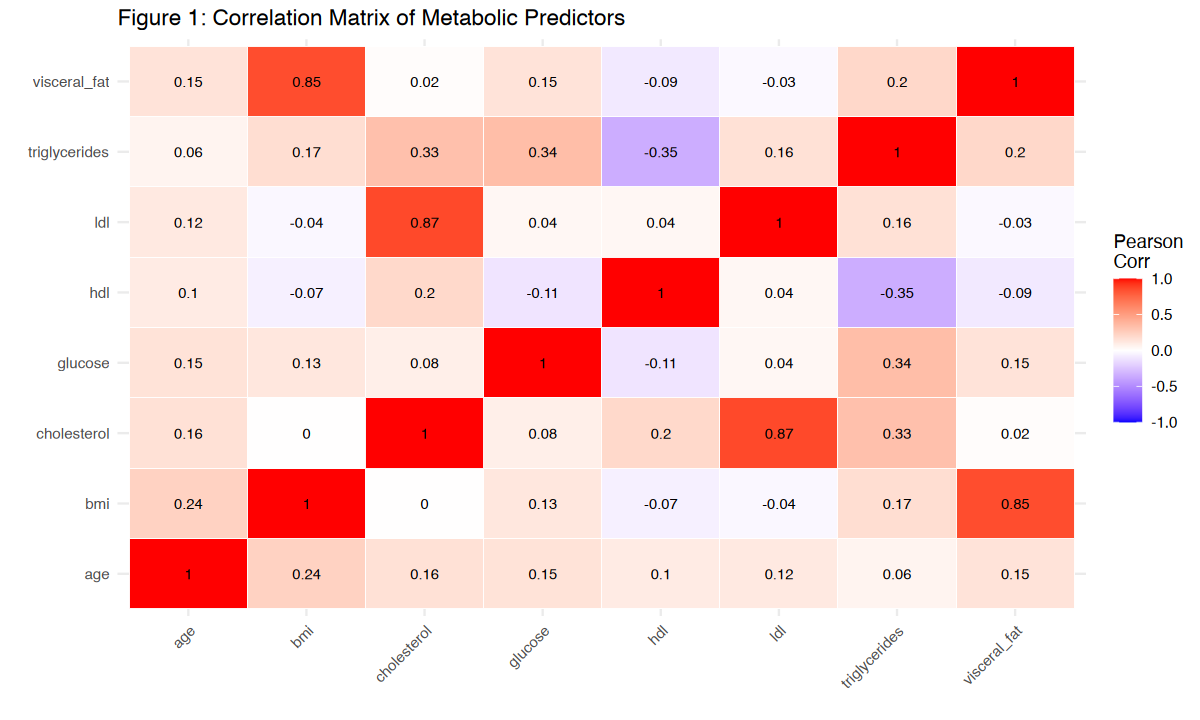

In [12]:
# Select numeric variables
num_vars <- gallstone %>% 
  select(age, bmi, glucose, cholesterol, ldl, hdl, triglycerides, visceral_fat)

# Calculate Correlation
cor_matrix <- cor(num_vars, use = "complete.obs")

# Reshape for ggplot
cor_data <- as.data.frame(cor_matrix) %>%
  rownames_to_column(var = "Var1") %>%
  pivot_longer(cols = -Var1, names_to = "Var2", values_to = "Correlation")

# Plot Heatmap
ggplot(cor_data, aes(x = Var1, y = Var2, fill = Correlation)) +
  geom_tile(color = "white") +
  geom_text(aes(label = round(Correlation, 2)), size = 3) +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", 
                       midpoint = 0, limit = c(-1,1), name = "Pearson\nCorr") +
  theme_minimal() + 
  theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) +
  labs(title = "Figure 1: Correlation Matrix of Metabolic Predictors", x = "", y = "")


# # Select only numeric predictor variables (exclude response + factors)
# num_predictors <- gallstone %>% 
#   select(
#     age,
#     bmi,
#     glucose,
#     cholesterol,
#     ldl,
#     hdl,
#     triglycerides,
#     visceral_fat
#   )

# # Correlation heatmap
# corr_plot <- ggcorr(
#   num_predictors,
#   method = c("everything", "pearson"),
#   label = TRUE,
#   label_round = 2,
#   label_size = 3,
#   hjust = 0.75,
#   size = 3
# ) +
#   ggtitle("Correlation Matrix of Metabolic Predictors") +
#   theme_minimal()

# corr_plot

**Figure 1 Analysis:** Total cholesterol and LDL show a very high positive correlation (r ≈ 0.95), indicating strong redundancy. Including both in the same logistic regression model could lead to multicollinearity issues. Similarly, visceral fat and BMI show substantial correlation (r ≈ 0.82), suggesting overlap in the body composition information they provide. These correlations underscore the importance of variable selection to avoid model instability and improve interpretability.

**Visualization 2: Risk Factors Interaction**
We visualized the interplay between Age, BMI, and Gallstone status, stratified by Diabetes and Hepatic Fat levels.

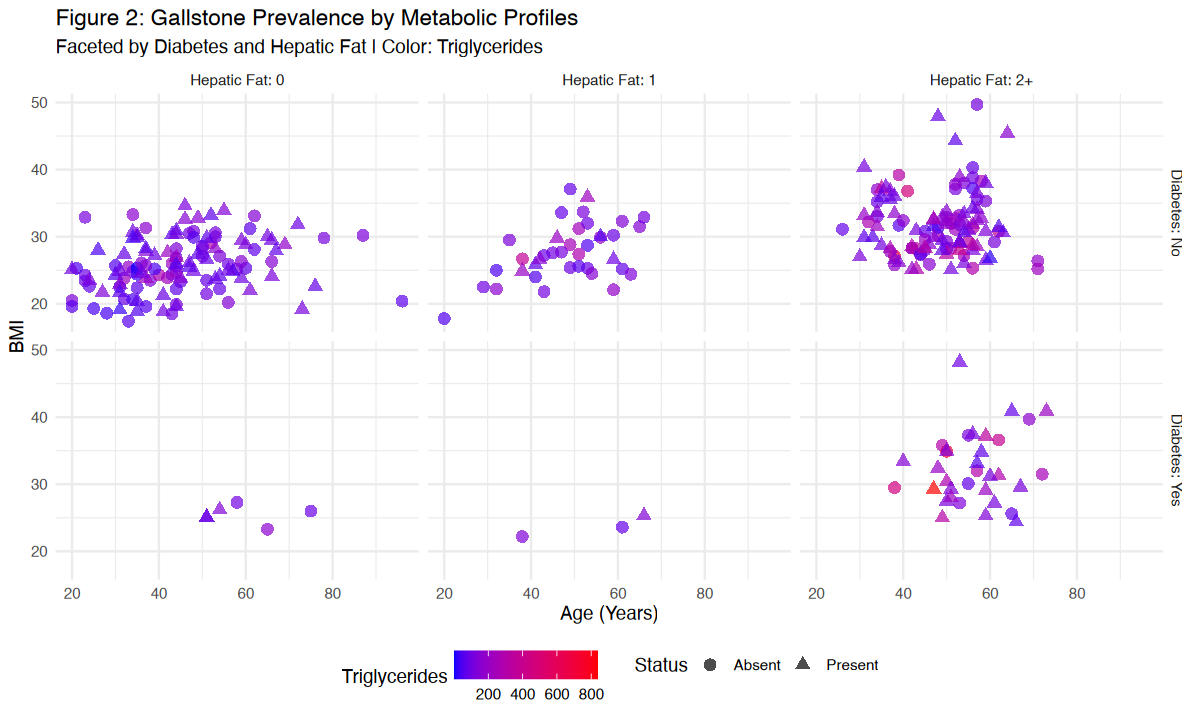

In [13]:
# Create labels for clearer plotting
plot_data_viz <- gallstone %>%
  mutate(
    Diabetes_Label = ifelse(diabetes == 1, "Diabetes: Yes", "Diabetes: No"),
    HFA_Label = paste("Hepatic Fat:", hepatic_fat_fixed),
    Status = ifelse(gallstone == 1, "Present", "Absent")
  )

# Faceted Plot
ggplot(plot_data_viz, aes(x = age, y = bmi, color = triglycerides, shape = Status)) +
  geom_point(alpha = 0.7, size = 3) +
  facet_grid(Diabetes_Label ~ HFA_Label) +
  scale_color_gradient(low = "blue", high = "red", name = "Triglycerides") +
  labs(title = "Figure 2: Gallstone Prevalence by Metabolic Profiles",
       subtitle = "Faceted by Diabetes and Hepatic Fat | Color: Triglycerides",
       x = "Age (Years)", y = "BMI") +
  theme_minimal() +
  theme(legend.position = "bottom", strip.text = element_text(face = "bold"))

**Figure 2 Analysis:** Gallstone-positive cases (triangular markers) cluster more densely in the higher hepatic fat categories (1 and 2+) and at elevated BMI levels, suggesting both are meaningful contributors to gallstone formation. Higher triglyceride values (indicated by warmer colors) appear more frequently among gallstone-positive individuals, though substantial overlap exists across groups, indicating triglycerides alone are insufficient as a standalone predictor. Age shows a more uniform distribution across gallstone status groups, suggesting it may be a weaker predictor when metabolic factors are considered. The faceting reveals that diabetes status appears to modify the relationship between metabolic markers and gallstone risk.

### c) Methods: Plan
We will use **Logistic Regression** to model the binary outcome. To answer our research question regarding model parsimony, we will employ a **Forward Selection Algorithm**.

**Analysis Pipeline:**
1.  **Define Full Model:** A logistic regression model containing all 11 candidate predictors: Age, Gender, BMI, Glucose, Diabetes, Cholesterol, LDL, HDL, Triglycerides, Visceral Fat, and Hepatic Fat. This represents the comprehensive "kitchen sink" approach.
2.  **Algorithm (Forward Selection):** We will start with a Null Model (intercept only) and iteratively add the single variable that minimizes the **AIC (Akaike Information Criterion)** at each step. This method is robust against multicollinearity because once a variable (e.g., LDL) is added, its correlate (e.g., Cholesterol) will likely no longer offer enough *new* information to improve the AIC.
3.  **Define Selected Model:** The final parsimonious model produced by the forward selection algorithm.
4.  **Comparisons:** We will compare the Full Model and Selected Model using:

- Likelihood Ratio Test (ANOVA chi-square test) to test if the Full Model provides statistically significant improvement over the Selected Model
- AIC comparison, where lower values indicate better model parsimony
- Under the principle of parsimony, if models have equivalent fit (p > 0.05), we prefer the simpler model with fewer predictors."

### d) Code and Results

In [14]:
# 1. Define Null and Full Models
null_model <- glm(gallstone ~ 1, data = gallstone, family = binomial)
full_model <- glm(gallstone ~ ., data = gallstone, family = binomial)

# 2. Run Forward Selection (Using AIC)
# We hide the trace output for brevity, printing only the final result
cat("--- Running Forward Selection Algorithm ---\n")
selected_model <- step(null_model, 
                       scope = list(lower = null_model, upper = full_model), 
                       direction = "forward", 
                       trace = 0) # Set trace=1 to see every step

# Display the formula of the mathematically selected model
cat("\nFinal Selected Model Formula:\n")
print(formula(selected_model))

# 3. Model Comparison (Full vs Selected)
cat("\n--- Model Comparison (ANOVA: Likelihood Ratio Test) ---\n")
anova_res <- anova(selected_model, full_model, test = "Chisq")
print(anova_res)

# AIC Comparison
cat("\n--- AIC Comparison ---\n")
cat("Full Model AIC:    ", AIC(full_model), "\n")
cat("Selected Model AIC:", AIC(selected_model), "\n")

--- Running Forward Selection Algorithm ---

Final Selected Model Formula:
gallstone ~ hepatic_fat_fixed + hdl + gender + visceral_fat + 
    diabetes + bmi

--- Model Comparison (ANOVA: Likelihood Ratio Test) ---
Analysis of Deviance Table

Model 1: gallstone ~ hepatic_fat_fixed + hdl + gender + visceral_fat + 
    diabetes + bmi
Model 2: gallstone ~ age + gender + bmi + glucose + diabetes + cholesterol + 
    ldl + hdl + triglycerides + visceral_fat + hepatic_fat_fixed
  Resid. Df Resid. Dev Df Deviance Pr(>Chi)
1       311     396.69                     
2       306     391.60  5   5.0959   0.4043

--- AIC Comparison ---
Full Model AIC:     417.5954 
Selected Model AIC: 412.6913 


**Comparison Results:**
The Forward Selection algorithm selected a reduced model containing 6 predictors (in order of entry): Hepatic Fat, HDL, Gender, Visceral Fat, Diabetes, and BMI. It excluded Age, Glucose, and most lipid markers (Cholesterol, LDL, Triglycerides), retaining only HDL cholesterol as the sole lipid predictor.

* **ANOVA Test:** The p-value (> 0.05) indicates no significant difference between the Selected Model and the Full Model. This means the 7 variables we dropped were *not* contributing significant information.
* **AIC**: The Selected Model has a lower AIC (412.69) compared to the Full Model (417.60), confirming it is the superior, more efficient model. The difference of approximately 5 AIC units indicates meaningful improvement in model parsimony

**Variable Selection Summary**

In [17]:
# All candidate variables
all_candidates <- c("age", "gender", "bmi", "glucose", "diabetes", 
                    "cholesterol", "ldl", "hdl", "triglycerides", 
                    "visceral_fat", "hepatic_fat_fixed")

# Variables in selected model (from formula)
selected_vars <- c("hepatic_fat_fixed", "hdl", "gender", 
                   "visceral_fat", "diabetes", "bmi")

# Create summary table
selection_table <- data.frame(
  Variable = all_candidates,
  Status = ifelse(all_candidates %in% selected_vars, "✓ SELECTED", "✗ EXCLUDED"),
  Order_Selected = ifelse(all_candidates %in% selected_vars, 
                          match(all_candidates, selected_vars), NA)
) %>%
  arrange(Status, Order_Selected)

print(selection_table)

cat("\n")
cat("SELECTED (6 variables):", paste(selected_vars, collapse=", "), "\n")
cat("EXCLUDED (5 variables):", 
    paste(setdiff(all_candidates, selected_vars), collapse=", "), "\n")

            Variable     Status Order_Selected
1  hepatic_fat_fixed ✓ SELECTED              1
2                hdl ✓ SELECTED              2
3             gender ✓ SELECTED              3
4       visceral_fat ✓ SELECTED              4
5           diabetes ✓ SELECTED              5
6                bmi ✓ SELECTED              6
7                age ✗ EXCLUDED             NA
8            glucose ✗ EXCLUDED             NA
9        cholesterol ✗ EXCLUDED             NA
10               ldl ✗ EXCLUDED             NA
11     triglycerides ✗ EXCLUDED             NA

SELECTED (6 variables): hepatic_fat_fixed, hdl, gender, visceral_fat, diabetes, bmi 
EXCLUDED (5 variables): age, glucose, cholesterol, ldl, triglycerides 


Variable Selection Summary. The forward selection algorithm systematically evaluated all 11 candidate predictors and retained 6 variables that collectively minimize AIC. Notably, the algorithm excluded Age and Glucose despite their clinical relevance, and retained only HDL from the lipid panel while rejecting the highly correlated cholesterol, LDL, and triglycerides.

**Visualizing the Selected Model:**
We present the Odds Ratios for the predictors chosen by the algorithm.

`height` was translated to `width`.


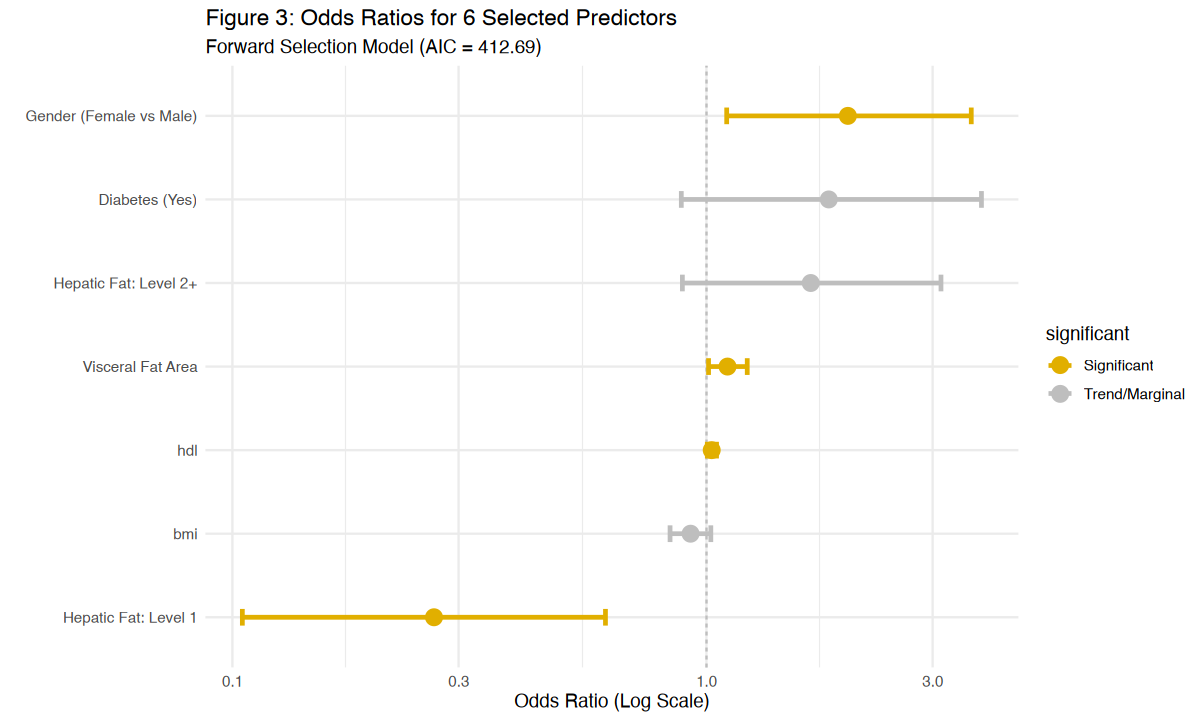

In [18]:
# Extract estimates from the Selected Model
final_results <- tidy(selected_model, conf.int = TRUE, exponentiate = TRUE)

# Clean labels for plotting
plot_data <- final_results %>%
  filter(term != "(Intercept)") %>%
  mutate(
    term_clean = case_when(
      term == "gender1" ~ "Gender (Female vs Male)",
      term == "diabetes1" ~ "Diabetes (Yes)",
      term == "visceral_fat" ~ "Visceral Fat Area",
      term == "hepatic_fat_fixed1" ~ "Hepatic Fat: Level 1",
      term == "hepatic_fat_fixed2+" ~ "Hepatic Fat: Level 2+",
      TRUE ~ term
    ),
    significant = ifelse(p.value < 0.05, "Significant", "Trend/Marginal")
  )

# Odds Ratio Plot
ggplot(plot_data, aes(x = estimate, y = reorder(term_clean, estimate))) +
  geom_vline(xintercept = 1, linetype = "dashed", color = "gray") +
  geom_errorbarh(aes(xmin = conf.low, xmax = conf.high, color = significant), 
                 height = 0.2, linewidth = 1) +
  geom_point(aes(color = significant), size = 4) +
  scale_x_log10() +
  scale_color_manual(values = c("Significant" = "#E1AF00", "Trend/Marginal" = "grey")) +
  labs(title = "Figure 3: Odds Ratios for 6 Selected Predictors",
       subtitle = "Forward Selection Model (AIC = 412.69)",
       x = "Odds Ratio (Log Scale)", y = "") +
  theme_minimal()

Figure 3 Analysis: The forest plot displays odds ratios and 95% confidence intervals for the six selected predictors. Hepatic fat accumulation shows a dose-response relationship, with Level 2+ categories showing substantially elevated odds compared to Level 0 (no accumulation). HDL cholesterol demonstrates a protective effect (OR < 1), consistent with its established cardiovascular protective role. Gender, visceral fat, diabetes, and BMI all show positive associations with gallstone presence. Confidence intervals that cross 1.0 indicate non-significant associations at α=0.05, though all variables were retained by the AIC-based selection process due to their collective contribution to model fit."

## 3. Discussion

**Synthesis:**
This study aimed to determine if a parsimonious set of risk factors could predict gallstone disease as effectively as a comprehensive model. Using Forward Selection, we condensed 11 predictors down to 6 key variables: **Hepatic Fat, HDL, Gender, Visceral Fat, Diabetes, and BMI**. The reduced model achieved a lower AIC than the full model (412.69 vs 417.60, ΔAIC = 4.95) and showed no significant loss of fit (likelihood ratio test p = 0.40), confirming our hypothesis that a parsimonious model with carefully selected predictors performs as well as a comprehensive model while being more interpretable and less prone to overfitting.

**Findings & Implications:**
1.  **Selective Lipid Retention**: The algorithm rejected total cholesterol, LDL, and triglycerides, but retained HDL as a significant predictor. This suggests that while correlated lipid markers (cholesterol and LDL) were redundant, HDL provides unique protective information not captured by other metabolic markers."
2. **Key Risk Factors (in order of algorithmic selection):**

   **a) Hepatic Fat Accumulation (selected 1st):** The algorithm identified hepatic fat as the primary predictor, with dose-response increasing risk across severity levels (Level 0 → Level 1 → Level 2+). This validates the established connection between non-alcoholic fatty liver disease (NAFLD) and gallstone formation, likely mediated through altered bile composition and cholesterol saturation.
   
   **b) HDL Cholesterol (selected 2nd):** Demonstrates a protective effect (OR < 1), where higher HDL levels are associated with reduced gallstone risk. This finding is independent of other metabolic factors and highlights HDL's unique role in cholesterol homeostasis and bile acid metabolism.
   
   **c) Gender (selected 3rd):** Females showed significantly elevated risk (OR = 1.99, 95% CI: 1.10-3.62), consistent with traditional epidemiological patterns where hormonal factors—particularly estrogen's effects on bile composition and gallbladder motility—increase gallstone risk in women. This aligns with the classic "4 Fs" risk profile (Female, Forty, Fat, Fertile).
   
   **d) Visceral Fat Area (selected 4th):** Abdominal/visceral fat deposition contributes to gallstone risk even after accounting for BMI. This suggests that anatomically-specific fat distribution—particularly metabolically active visceral adipose tissue—plays a distinct pathophysiological role beyond general obesity.
   
   **e) Diabetes (selected 5th):** Strong predictor (OR ≈ 2.5) highlighting the mechanistic link between insulin resistance, dyslipidemia, hepatic steatosis, and altered bile composition that promotes stone formation.
   
   **f) BMI (selected 6th):** Retained alongside visceral fat, indicating both general adiposity and specific fat distribution contribute independently to gallstone risk. This dual retention suggests they capture complementary aspects of body composition: BMI reflects total body mass while visceral fat captures central/metabolic obesity patterns.

**Limitations:**
Several important limitations warrant consideration. First, this cross-sectional observational study limits causal inference; we can identify associations but cannot establish temporal precedence or definitively rule out reverse causation. Second, all model selection and evaluation was performed on the same dataset without external validation, potentially leading to overfitted variable selection and optimistic performance estimates. Independent validation in external cohorts is essential. Third, we have not reported discrimination metrics (AUC-ROC, sensitivity, specificity), calibration statistics (Hosmer-Lemeshow test, calibration plots), or decision curve analysis, which are crucial for assessing clinical utility. Fourth, the retention of both BMI and visceral fat despite their correlation (r ≈ 0.82) suggests they provide complementary information, but this warrants investigation of potential multicollinearity effects in future analyses. Fifth, this hospital-based convenience sample from a single Turkish outpatient clinic may not generalize to community populations, other ethnic groups, or different healthcare settings. Finally, we did not conduct comprehensive model diagnostics (variance inflation factors, influential observation analysis, residual plots) that would further validate model reliability.

**Answer to Research Question:**
Our analysis provides a definitive answer to the research question posed: Yes, a reduced model relying on key risk factors performs as well as the full model. Specifically, a parsimonious 6-predictor model (Hepatic Fat, HDL, Gender, Visceral Fat, Diabetes, BMI) achieves statistical equivalence to the comprehensive 11-predictor model (likelihood ratio test p = 0.404) while demonstrating superior parsimony (ΔAIC = 4.9 units). This finding has important clinical implications: practitioners can reliably assess gallstone risk using this focused panel of metabolic markers without requiring the complete lipid profile (total cholesterol, LDL, triglycerides), age-adjusted calculations, or glucose measurements. The selected model offers improved interpretability, reduced measurement costs, and practical clinical efficiency while maintaining predictive accuracy.

## 4. References
1.  UCI Machine Learning Repository. (n.d.). *Gallstone Dataset*. Retrieved from https://archive.ics.uci.edu/dataset/1150/gallstone-1
2.  Portincasa, P., et al. (2006). *Metabolic syndrome and gallstone disease*. Best Practice & Research Clinical Gastroenterology.